In [1]:
#this notebook is for getting results for each year independentally with all the languages

In [2]:
import joblib
from sklearn.metrics import accuracy_score,f1_score
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics.pairwise import manhattan_distances
import numpy as np
import seaborn as sns
from tqdm import tqdm
import pandas as pd
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

In [3]:
df=pd.read_csv('dfV2_lite.csv')

In [4]:
df=df.reset_index()
df.drop('index',inplace=True,axis=1)
df.head()

,year,username,language,obfuscated,file_length
0,2008,bhamrick,cpp,0,900
1,2008,bhamrick,cpp,0,3154
2,2008,Davidsu,cpp,0,838
3,2008,matkk,cpp,0,2140
4,2008,Sorokin,cpp,0,2497


In [5]:
X,y=joblib.load('struct-char-tan-BIG-500.joblib')

In [6]:
def get_train_test(X,y,df,year,train_sample=4,test_sample=1,obfuscated=-1,lang=-1):
    X_train=[]
    y_train=[]
    X_test=[]
    y_test=[]
    #else all languages will be inlcuded
    if lang!=-1:
        df=df[df['language']==lang]
    #else both will be included
    if obfuscated!=-1:
        if obfuscated:
            df=df[df['obfuscated']==1]
        elif obfuscated==0:
            df=df[df['obfuscated']==0]
    df=df[df['year']==year]
    unique_users=df.drop_duplicates('username')['username'].tolist()
    for uu in unique_users:
        code_samples=df[df['username']==uu].index.tolist()
        if len(code_samples)<train_sample+test_sample:
            for code_sample in code_samples:
                X_test.append(X[int(code_sample)])
                y_test.append('outside')
        else:
            sampled_codes=np.random.choice(code_samples,train_sample+test_sample,replace=False)
            for code_sample in sampled_codes[:-1]:
                X_train.append(X[int(code_sample)])
                y_train.append(y[int(code_sample)])
           
            X_test.append(X[int(sampled_codes[-1])])
            y_test.append(y[int(sampled_codes[-1])])
    return X_train,y_train,X_test,y_test

In [7]:
def get_dists(X):
    dists=manhattan_distances(X)
    total=[]
    for i in range(len(dists)):
        total.extend(dists[i][i+1:])
    return total

In [8]:
def cal_dists(df,year):
    df=df[df['year']==year]
    unique_users=df.drop_duplicates('username')['username'].tolist()
    dists=[]
    for uu in tqdm(unique_users):
        code_vecs=[]
        code_samples=df[df['username']==uu].index.tolist()
        for code_sample in code_samples:
            code_vecs.append(X[int(code_sample)])
        dists.extend(get_dists(code_vecs))
    return dists

In [9]:
dists=cal_dists(df,2018)

100%|██████████| 16019/16019 [07:52<00:00, 33.92it/s]


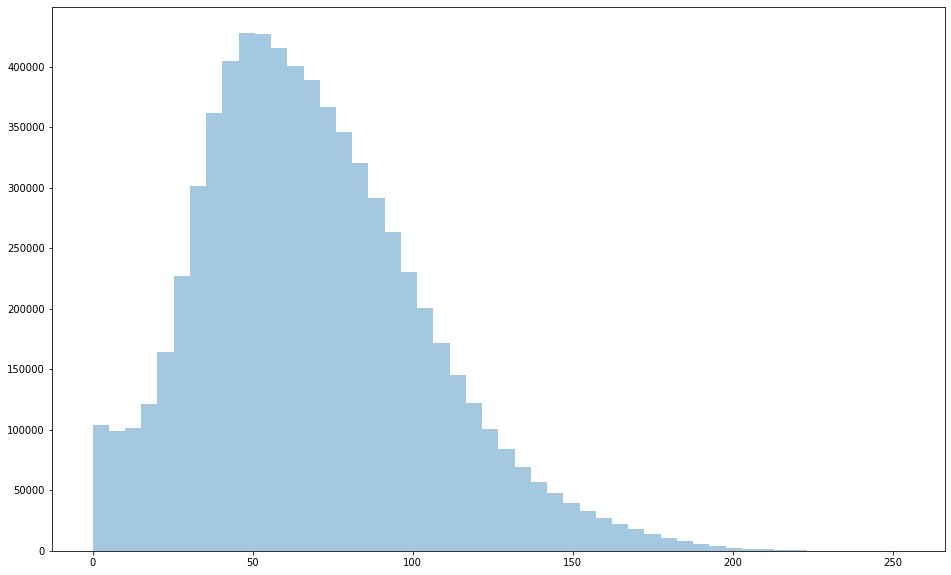

In [10]:
plt.figure(figsize=(16,10))
sns.distplot(dists,kde=False)

In [11]:
len(dists)

6952621

In [12]:
np.sum(np.array(dists)>246)

8

In [13]:
np.quantile(dists,q=[0.999])

array([198.37984147])

In [14]:
np.mean(dists)

68.92437295445197

In [15]:
np.median(dists)

64.90325381280854

In [16]:
np.std(dists)

35.01644237443612

In [17]:
class NNC:
    def __init__(self):
        self.X=None
        self.y=None
        
    def fit(self,X,y):
        self.X=X
        self.y=y
        
    def predict(self,X_test,thresh):
        preds=[]
        dists=manhattan_distances(X_test,self.X)
        for dist in dists:
            if np.min(dist)>=thresh:
                preds.append('outside')
            else:
                idx=dist.argmin()
                preds.append(self.y[idx])
        return preds

# Mixed setting all languages

In [20]:
dataset_X=[]
dataset_y=[]
dataset_X_test=[]
dataset_y_test=[]
for i in tqdm(range(1,11)):
    X_train,y_train,X_test,y_test=get_train_test(X,y,df,2008,train_sample=8,test_sample=1)
    dataset_X.append(X_train)
    dataset_y.append(y_train)
    dataset_X_test.append(X_test)
    dataset_y_test.append(y_test)

100%|██████████| 10/10 [03:02<00:00, 18.26s/it]


In [21]:
start=np.mean(dists)
init_jump=np.std(dists)/2
intervals=[start]
jump=init_jump
for i in range(4):
    print(jump)
    intervals.append(start+jump)
    if start-jump<0:
        intervals.append(0)
    else:
        intervals.append(start-jump)
    jump+=init_jump
intervals

17.50822118721806
35.01644237443612
52.52466356165418
70.03288474887223


[68.92437295445197,
 86.43259414167002,
 51.41615176723391,
 103.94081532888808,
 33.90793058001585,
 121.44903651610615,
 16.39970939279779,
 138.95725770332422,
 0]

In [22]:
results_overall_dict={}
for interval in intervals:
    results_overall_dict[str(interval)]={'percision':[],'recall':[]}
results_overall_dict

{'68.92437295445197': {'percision': [], 'recall': []},
 '86.43259414167002': {'percision': [], 'recall': []},
 '51.41615176723391': {'percision': [], 'recall': []},
 '103.94081532888808': {'percision': [], 'recall': []},
 '33.90793058001585': {'percision': [], 'recall': []},
 '121.44903651610615': {'percision': [], 'recall': []},
 '16.39970939279779': {'percision': [], 'recall': []},
 '138.95725770332422': {'percision': [], 'recall': []},
 '0': {'percision': [], 'recall': []}}

In [23]:
results_outside_dict={}
for interval in intervals:
    results_outside_dict[str(interval)]={'percision':[],'recall':[]}
results_outside_dict

{'68.92437295445197': {'percision': [], 'recall': []},
 '86.43259414167002': {'percision': [], 'recall': []},
 '51.41615176723391': {'percision': [], 'recall': []},
 '103.94081532888808': {'percision': [], 'recall': []},
 '33.90793058001585': {'percision': [], 'recall': []},
 '121.44903651610615': {'percision': [], 'recall': []},
 '16.39970939279779': {'percision': [], 'recall': []},
 '138.95725770332422': {'percision': [], 'recall': []},
 '0': {'percision': [], 'recall': []}}

In [24]:
for interval in tqdm(intervals):
    for i in tqdm(range(len(dataset_X))):
        neigh = NNC()
        neigh.fit(dataset_X[i], dataset_y[i])
        y_pred=neigh.predict(dataset_X_test[i],interval)
        results=classification_report(dataset_y_test[i],y_pred)
        results_outside_dict[str(interval)]['percision'].append(results[results.find('outside'):].split('\n')[0].split()[-4])
        results_outside_dict[str(interval)]['recall'].append(results[results.find('outside'):].split('\n')[0].split()[-3])
        results_overall_dict[str(interval)]['percision'].append(results[results.find('macro avg'):].split('\n')[0].split()[-4])
        results_overall_dict[str(interval)]['recall'].append(results[results.find('macro avg'):].split('\n')[0].split()[-3])

  0%|          | 0/10 [00:00<?, ?it/s]/home/sarim/anaconda3/envs/deep/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)

 10%|█         | 1/10 [00:24<03:39, 24.35s/it]/home/sarim/anaconda3/envs/deep/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)

 20%|██        | 2/10 [00:47<03:10, 23.85s/it]/home/sarim/anaconda3/envs/deep/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)

 30%|███       | 3/10 [01:09<02:44, 23.45s/it]/home/sarim/anaconda

 60%|██████    | 6/10 [02:52<01:56, 29.12s/it]/home/sarim/anaconda3/envs/deep/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)

 70%|███████   | 7/10 [03:22<01:28, 29.36s/it]/home/sarim/anaconda3/envs/deep/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)

 80%|████████  | 8/10 [03:49<00:57, 28.77s/it]/home/sarim/anaconda3/envs/deep/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)

 90%|█████████ | 9/10 [04:18<00:28, 28.86s/it]/home/sarim/

 10%|█         | 1/10 [00:33<04:58, 33.20s/it]/home/sarim/anaconda3/envs/deep/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)

 20%|██        | 2/10 [01:01<04:13, 31.63s/it]/home/sarim/anaconda3/envs/deep/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)

 30%|███       | 3/10 [01:29<03:33, 30.49s/it]/home/sarim/anaconda3/envs/deep/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)

 40%|████      | 4/10 [02:03<03:10, 31.73s/it]/home/sarim/

 70%|███████   | 7/10 [03:44<01:38, 32.71s/it]/home/sarim/anaconda3/envs/deep/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)

 80%|████████  | 8/10 [04:12<01:02, 31.40s/it]/home/sarim/anaconda3/envs/deep/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)

 90%|█████████ | 9/10 [04:39<00:29, 29.89s/it]/home/sarim/anaconda3/envs/deep/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)

  0%|          | 0/10 [00:00<?, ?it/s]/home/sarim/anaconda

In [25]:
#results_outside_dict_copy=results_outside_dict
#results_overall_dict_copy=results_overall_dict

In [26]:
# convert the diction to dataframe
import pandas as pd

outside_df=pd.DataFrame.from_dict(results_outside_dict, orient='index').reset_index()

overall_df=pd.DataFrame.from_dict(results_overall_dict, orient='index').reset_index()


In [27]:
overall_df['mean_percision']=0
overall_df['mean_recall']=0
overall_df['std_percision']=0
overall_df['std_recall']=0

outside_df['mean_recall']=0
outside_df['mean_percision']=0
outside_df['std_percision']=0
outside_df['std_recall']=0

for i in range(len(overall_df)):
    overall_df['mean_percision'].iloc[i]=np.mean(np.array(overall_df['percision'].iloc[i]).astype(np.float))
    overall_df['mean_recall'].iloc[i]=np.mean(np.array(overall_df['recall'].iloc[i]).astype(np.float))
    overall_df['std_percision'].iloc[i]=np.std(np.array(overall_df['percision'].iloc[i]).astype(np.float))
    overall_df['std_recall'].iloc[i]=np.std(np.array(overall_df['recall'].iloc[i]).astype(np.float))

    outside_df['mean_percision'].iloc[i]=np.mean(np.array(outside_df['percision'].iloc[i]).astype(np.float))
    outside_df['mean_recall'].iloc[i]=np.mean(np.array(outside_df['recall'].iloc[i]).astype(np.float))
    outside_df['std_percision'].iloc[i]=np.std(np.array(outside_df['percision'].iloc[i]).astype(np.float))
    outside_df['std_recall'].iloc[i]=np.std(np.array(outside_df['recall'].iloc[i]).astype(np.float))


/home/sarim/anaconda3/envs/deep/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [28]:

outside_df['index']=outside_df['index'].astype('float64')
overall_df['index']=overall_df['index'].astype('float64')

outside_df=outside_df.sort_values(by=['index']).reset_index(drop=True)
overall_df=overall_df.sort_values(by=['index']).reset_index(drop=True)


In [29]:
overall_df

,index,percision,recall,mean_percision,mean_recall,std_percision,std_recall
0,0.000000,"[0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.0...","[0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.0...",0.000,0.000,0.000000,0.000000
1,16.399709,"[0.18, 0.20, 0.18, 0.18, 0.19, 0.17, 0.19, 0.1...","[0.18, 0.20, 0.19, 0.18, 0.19, 0.18, 0.19, 0.1...",0.185,0.187,0.009220,0.007810
2,33.907931,"[0.36, 0.38, 0.38, 0.37, 0.37, 0.37, 0.39, 0.3...","[0.37, 0.39, 0.39, 0.38, 0.38, 0.38, 0.40, 0.3...",0.373,0.383,0.009000,0.009000
3,51.416152,"[0.65, 0.65, 0.65, 0.65, 0.64, 0.66, 0.67, 0.6...","[0.72, 0.72, 0.72, 0.72, 0.71, 0.73, 0.74, 0.7...",0.653,0.722,0.009000,0.008718
4,68.924373,"[0.60, 0.60, 0.61, 0.60, 0.58, 0.61, 0.62, 0.6...","[0.85, 0.85, 0.85, 0.85, 0.84, 0.86, 0.87, 0.8...",0.605,0.854,0.011180,0.008000
5,86.432594,"[0.51, 0.50, 0.50, 0.51, 0.49, 0.51, 0.52, 0.5...","[0.87, 0.88, 0.87, 0.87, 0.86, 0.88, 0.89, 0.8...",0.506,0.874,0.008000,0.008000
6,103.940815,"[0.49, 0.49, 0.49, 0.49, 0.48, 0.49, 0.50, 0.4...","[0.87, 0.88, 0.87, 0.87, 0.86, 0.88, 0.89, 0.8...",0.491,0.875,0.005385,0.008062
7,121.449037,"[0.49, 0.49, 0.49, 0.49, 0.48, 0.49, 0.50, 0.4...","[0.87, 0.88, 0.87, 0.87, 0.86, 0.88, 0.89, 0.8...",0.492,0.875,0.006000,0.008062
8,138.957258,"[0.49, 0.49, 0.49, 0.49, 0.48, 0.49, 0.50, 0.4...","[0.87, 0.88, 0.87, 0.87, 0.86, 0.88, 0.89, 0.8...",0.492,0.875,0.006000,0.008062


In [30]:
outside_df

,index,percision,recall,mean_recall,mean_percision,std_percision,std_recall
0,0.000000,"[0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.6...","[1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.0...",1.000,0.690,1.110223e-16,0.000000e+00
1,16.399709,"[0.73, 0.73, 0.73, 0.73, 0.73, 0.73, 0.73, 0.7...","[0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.9...",0.990,0.730,1.110223e-16,0.000000e+00
2,33.907931,"[0.78, 0.78, 0.78, 0.78, 0.78, 0.78, 0.79, 0.7...","[0.98, 0.98, 0.98, 0.98, 0.98, 0.98, 0.98, 0.9...",0.980,0.781,3.000000e-03,1.110223e-16
3,51.416152,"[0.89, 0.88, 0.88, 0.88, 0.88, 0.89, 0.89, 0.8...","[0.84, 0.84, 0.84, 0.84, 0.84, 0.84, 0.84, 0.8...",0.840,0.885,5.000000e-03,1.110223e-16
4,68.924373,"[0.93, 0.94, 0.94, 0.93, 0.93, 0.94, 0.94, 0.9...","[0.39, 0.40, 0.40, 0.40, 0.39, 0.41, 0.40, 0.4...",0.399,0.937,4.582576e-03,5.385165e-03
5,86.432594,"[0.92, 0.93, 0.92, 0.92, 0.94, 0.93, 0.92, 0.9...","[0.06, 0.06, 0.05, 0.06, 0.05, 0.05, 0.05, 0.0...",0.056,0.927,7.810250e-03,4.898979e-03
6,103.940815,"[1.00, 1.00, 1.00, 0.83, 0.83, 0.75, 0.86, 0.9...","[0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.0...",0.000,0.862,1.092520e-01,0.000000e+00
7,121.449037,"[0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.0...","[0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.0...",0.000,0.000,0.000000e+00,0.000000e+00
8,138.957258,"[0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.0...","[0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.0...",0.000,0.000,0.000000e+00,0.000000e+00


In [31]:
e = np.array(outside_df['std_percision'])
print(e)

[1.11022302e-16 1.11022302e-16 3.00000000e-03 5.00000000e-03
 4.58257569e-03 7.81024968e-03 1.09252002e-01 0.00000000e+00
 0.00000000e+00]


[0.00000000e+00 0.00000000e+00 1.11022302e-16 1.11022302e-16
 5.38516481e-03 4.89897949e-03 0.00000000e+00 0.00000000e+00
 0.00000000e+00]


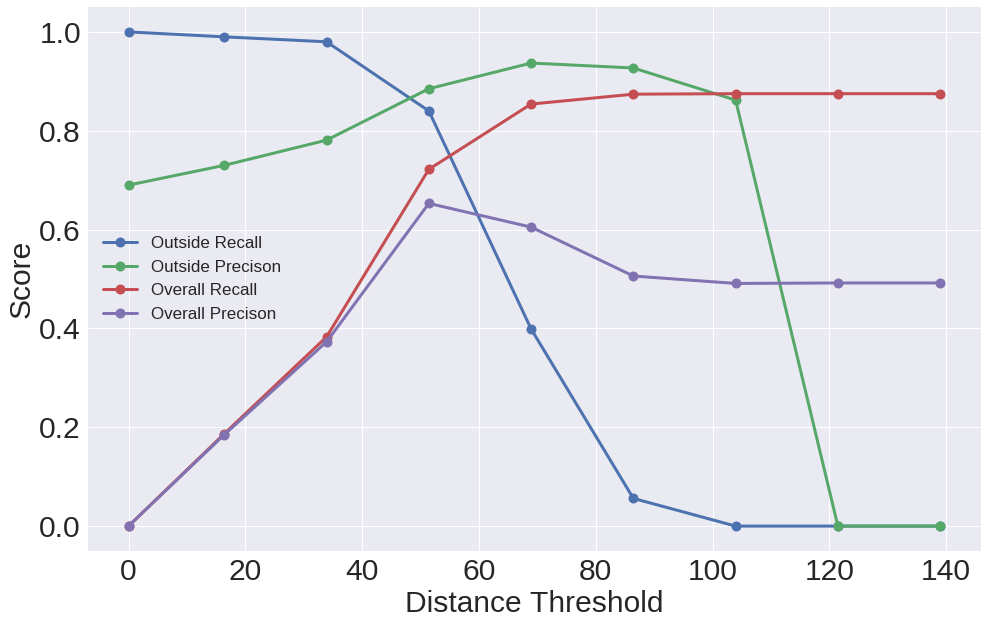

In [32]:
import matplotlib.pyplot as plt
import numpy as np


plt.style.use('seaborn')

params = {'axes.labelsize': 30,'axes.titlesize':30, 'font.size': 30,'legend.fontsize': 17,'xtick.labelsize': 30, 'ytick.labelsize': 30}
plt.rcParams.update(params)
plt.rcParams["font.size"] = "50"
plt.figure(figsize=(16,10))

#plt.rcParams.update({'font.size': 40})
#plt.rcParams.update({'lines.markeredgewidth': 1})

x = np.round(outside_df['index'], decimals=2)
y = np.array(outside_df['mean_recall'])
e = np.array(outside_df['std_recall'])


plt.errorbar(x, y, marker='o',linewidth=3, markersize='10')


x = np.round(outside_df['index'], decimals=2)
y = np.array(outside_df['mean_percision'])
#e = np.array(outside_df['std_percision'])
print(e)
plt.errorbar(x, y, marker='o',linewidth=3, markersize='10')


x = np.round(overall_df['index'], decimals=2)
y = np.array(overall_df['mean_recall'])
#e = np.array(overall_df['std_recall'])

plt.errorbar(x, y, marker='o',linewidth=3, markersize='10')

x = np.round(overall_df['index'], decimals=2)
y = np.array(overall_df['mean_percision'])
e = np.array(overall_df['std_percision'])




plt.errorbar(x, y, marker='o',linewidth=3, markersize='10')
plt.legend(['Outside Recall','Outside Precison','Overall Recall','Overall Precison'])

plt.gca().set_ylabel("Score")
plt.gca().set_xlabel("Distance Threshold")


#plt.rcParams.update({'font.size': 45})



plt.savefig('open_world_500.eps')